In [1]:
import os
if os.name=='nt':
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time

%matplotlib inline

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [3]:
def bayesian_time_diff(x_train, x_test, suffix, shift, feat):
    '''
    Calculate bayesian mean time difference between neighboring failures.
    shift=n, n>0: n next failures
    shift=n, n<0: n previous failures
    x_train: has Response column
    x_test: does not have Response column, other columns should be the same as x_train
    feat: feature used for sorting and calculating distance
    '''
    assert(shift!=0), 'shift cannot equal 0!'
    
    # calculate 1st distance
    x = pd.concat([x_train, x_test]).fillna(0)
    x['idx'] = np.arange(len(x), dtype=np.int32)
    n_train = len(x_train)
    x['Response'] = x['Response'].astype(int)
    x.sort_values(feat, axis=0, inplace=True)
    
    x['res1'] = x['Response']
    x.loc[x['Response']==1, 'res1'] = x.loc[x['Response']==1, feat]
    if shift<0:
        x['res1'] = x[feat] - x['res1'].shift(1).fillna(0).replace(0, method='ffill')
    elif shift>0:
        x['res1'] = x['res1'].shift(-1).fillna(9999).replace(0, method='bfill') - x[feat]
        
    shift_abs = np.abs(shift)
    if shift_abs>1:
        for n in range(2, shift_abs+1):
            x['res'+str(n)] = x['Response']
            x.loc[x['Response']==1, 'res'+str(n)] = x.loc[x['Response']==1, 'res'+str(n-1)]
            if shift<0:
                x['res'+str(n)] = x['res'+str(n)].shift(1).fillna(0).replace(0, method='ffill') + x['res'+str(n-1)]
            elif shift>0:
                x['res'+str(n)] = x['res'+str(n)].shift(-1).fillna(9999).replace(0, method='bfill') + x['res'+str(n-1)]

    x[feat+suffix] = x[['res'+str(n) for n in range(1, shift_abs+1)]].mean(axis=1)
    x.drop(['res'+str(n) for n in range(1, shift_abs+1)], axis=1, inplace=True)
    x.sort_values('idx', axis=0, inplace=True)
    x.drop('idx', axis=1, inplace=True)
    x_train0 = x.iloc[:n_train]
    x_test0 = x.iloc[n_train:]
    x_test0.drop('Response', axis=1, inplace=True)
    
    return x_train0, x_test0


#suffix = ['_{}_{}{}'.format(f.split('_')[1], 'p' if s>0 else 'm', abs(s)) for f in feats for s in shifts]

def bayesian_generate_all(x_train, x_test):
    shifts = [-10, -5, -1, 1, 5, 10]
    feats = ['time_min', 'time_max']
    x_train_new = []
    x_test_new = []
    for s in shifts:
        for f in feats:
            suffix = '_{}_{}{}'.format(f.split('_')[1], 'p' if s>0 else 'm', abs(s))
            tmp_train, tmp_test = bayesian_time_diff(x_train, x_test, suffix, s, f)
            tmp_train.drop(['time_min', 'time_max', 'Response'], axis=1, inplace=True)
            tmp_test.drop(['time_min', 'time_max'], axis=1, inplace=True)
            x_train_new.append(tmp_train)
            x_test_new.append(tmp_test)
    
    x_train_new = x_train_new[0].join(x_train_new[1:])
    x_test_new = x_test_new[0].join(x_test_new[1:])
    
    return x_train_new.values, x_test_new.values

time_all = pd.read_csv('time_all.csv.gz', index_col=0)

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


u = time_all.iloc[:1183747].copy()
u.drop(['idx'], axis=1, inplace=True)
v = time_all.iloc[1183747:].copy()
v.drop(['idx', 'Response'], axis=1, inplace=True)

u0, v0 = bayesian_generate_all(u, v)

In [4]:
x_train0 = read_pickle('x_train_date_feats_0.pickle')
x_test = read_pickle('x_test_date_feats_0.pickle')

In [5]:
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
y_train0 = response.values.ravel()

In [7]:
idx0 = np.arange(x_train0.shape[0])
x_train, x_val, y_train, y_val, idx_train, idx_val = train_test_split(x_train0, y_train0, idx0, 
                                                                      test_size=0.2, random_state=23435)

time_train = time_all.iloc[idx_train].copy()
time_train.drop(['idx'], axis=1, inplace=True)
time_val = time_all.iloc[idx_val].copy()
time_val.drop(['idx', 'Response'], axis=1, inplace=True)

time_train, time_val = bayesian_generate_all(time_train, time_val)

x_train = np.concatenate((x_train, time_train), axis=1)
x_val = np.concatenate((x_val, time_val), axis=1)

time_train0 = time_all.iloc[:1183747].copy()
time_train0.drop(['idx'], axis=1, inplace=True)
time_test = time_all.iloc[1183747:].copy()
time_test.drop(['idx', 'Response'], axis=1, inplace=True)

time_train0, time_test = bayesian_generate_all(time_train0, time_test)

x_train0 = np.concatenate((x_train0, time_train0), axis=1)
x_test = np.concatenate((x_test, time_test), axis=1)

cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=0)

preds = np.ones(y_train.shape[0])
for i, (train, test) in enumerate(cv):
    clf.fit(x_train[train], y_train[train], 
                          eval_set=[(x_val, y_val)], eval_metric='auc', 
                          early_stopping_rounds=10)
    models.append(clf)
    preds[test] = clf.predict_proba(x_train[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y_train[test], preds[test])))
print(roc_auc_score(y_train, preds))

In [8]:
n_estimators = 400
clf = XGBClassifier(max_depth=14, n_estimators=n_estimators, base_score=0.0058, n_jobs=8, colsample_bytree=0.6,
                   min_child_weight=5, subsample=0.9,  reg_lambda=4, silent=False, learning_rate=0.03, random_state=12393)

clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.911798
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.912233
[2]	validation_0-auc:0.913288
[3]	validation_0-auc:0.914077
[4]	validation_0-auc:0.913486
[5]	validation_0-auc:0.913799
[6]	validation_0-auc:0.914089
[7]	validation_0-auc:0.914429
[8]	validation_0-auc:0.913782
[9]	validation_0-auc:0.914319
[10]	validation_0-auc:0.914504
[11]	validation_0-auc:0.915182
[12]	validation_0-auc:0.916442
[13]	validation_0-auc:0.916336
[14]	validation_0-auc:0.916215
[15]	validation_0-auc:0.916181
[16]	validation_0-auc:0.916702
[17]	validation_0-auc:0.916841
[18]	validation_0-auc:0.91712
[19]	validation_0-auc:0.917281
[20]	validation_0-auc:0.917786
[21]	validation_0-auc:0.917971
[22]	validation_0-auc:0.917898
[23]	validation_0-auc:0.917744
[24]	validation_0-auc:0.917902
[25]	validation_0-auc:0.918034
[26]	validation_0-auc:0.91797
[27]	validation_0-auc:0.917867
[28]	validation_0-auc:0.918207
[29]	validation_0-auc:0.918374
[30]	validation_0-

XGBClassifier(base_score=0.0058, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=14, min_child_weight=5, missing=None, n_estimators=400,
       n_jobs=8, nthread=None, objective='binary:logistic',
       random_state=12393, reg_alpha=0, reg_lambda=4, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.9)

In [9]:
if clf.best_ntree_limit:
    n_estimators = int(clf.best_ntree_limit * 1.2)

clf.n_estimators = n_estimators

In [10]:
n_estimators

64

In [11]:
clf.fit(x_train0, y_train0, eval_set=[(x_train0, y_train0)], eval_metric='auc')

[0]	validation_0-auc:0.916205
[1]	validation_0-auc:0.922154
[2]	validation_0-auc:0.925748
[3]	validation_0-auc:0.927511
[4]	validation_0-auc:0.929214
[5]	validation_0-auc:0.929978
[6]	validation_0-auc:0.930525
[7]	validation_0-auc:0.931241
[8]	validation_0-auc:0.932364
[9]	validation_0-auc:0.933025
[10]	validation_0-auc:0.93392
[11]	validation_0-auc:0.93433
[12]	validation_0-auc:0.935553
[13]	validation_0-auc:0.936365
[14]	validation_0-auc:0.936381
[15]	validation_0-auc:0.936564
[16]	validation_0-auc:0.936754
[17]	validation_0-auc:0.937095
[18]	validation_0-auc:0.93734
[19]	validation_0-auc:0.938057
[20]	validation_0-auc:0.938349
[21]	validation_0-auc:0.938626
[22]	validation_0-auc:0.939843
[23]	validation_0-auc:0.940533
[24]	validation_0-auc:0.940662
[25]	validation_0-auc:0.940837
[26]	validation_0-auc:0.94171
[27]	validation_0-auc:0.942023
[28]	validation_0-auc:0.942773
[29]	validation_0-auc:0.943052
[30]	validation_0-auc:0.943646
[31]	validation_0-auc:0.94432
[32]	validation_0-auc:0

XGBClassifier(base_score=0.0058, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=14, min_child_weight=5, missing=None, n_estimators=64,
       n_jobs=8, nthread=None, objective='binary:logistic',
       random_state=12393, reg_alpha=0, reg_lambda=4, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.9)

In [12]:
preds = clf.predict_proba(x_train0)
preds = preds[:, 1]

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.4628266279466398


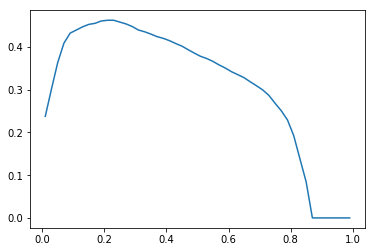

In [13]:
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y_train0, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [14]:
preds = (clf.predict_proba(x_test)[:, 1]>best_threshold).astype(np.int8)
sub = pd.read_csv('data/sample_submission.csv.zip', index_col=0)
sub['Response'] = preds
sub.to_csv('submission_train_time_features.csv.gz', compression='gzip')

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
